In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
RANDOM_SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
print(image.shape, class_names[label])

torch.Size([1, 28, 28]) Ankle boot


(-0.5, 27.5, 27.5, -0.5)

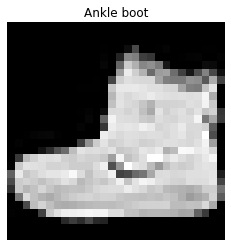

In [5]:
plt.imshow(image.squeeze(), cmap='gray') # cmap can be c
plt.title(class_names[label])
plt.axis(False)

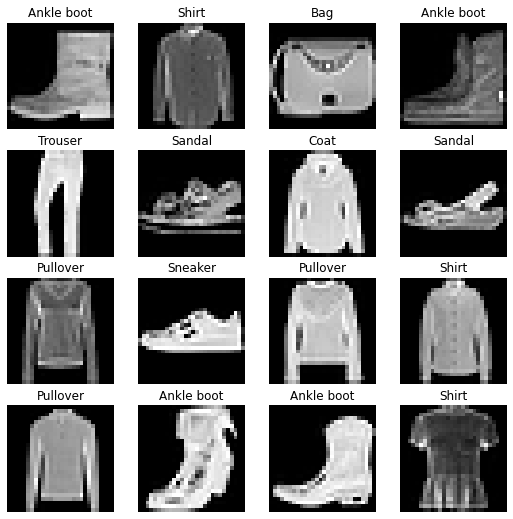

In [6]:
torch.manual_seed(RANDOM_SEED)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader = DataLoader(dataset=train_data,
                         batch_size=BATCH_SIZE,
                         shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)
print(len(train_dataloader))

1875


(-0.5, 27.5, 27.5, -0.5)

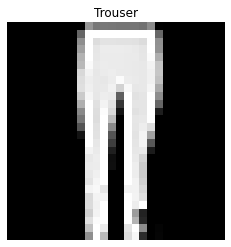

In [8]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)

In [10]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print('Exists')
else:
    print('Downloading')
    request = requests.get()
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
        
from helper_functions import accuracy_fn

Exists


In [11]:
from timeit import default_timer as timer

def print_train_time(start:float, end:float, device:torch.device=None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
    
start_time = timer()
end_time = timer()
print_train_time(start_time, end_time, device)

Train time on cpu: 0.000 seconds


2.390000000218606e-05

In [13]:
def train_step(model, data_loader, loss_fn, optim, accuracy_fn, device=device):
    """Performs a training loop step on model going over data_loader"""
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):        
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if batch % 400 == 0:
            print(f"Batch {batch*len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train Loss: {train_loss:.5f} Train Acc: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(model, data_loader, loss_fn, accuracy_fn, device=device):
    """Performs a testing loop step on model going over data_loader"""
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} Test acc: {test_acc:.2f}%\n")

In [12]:
def eval_model(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader, loss_fn:torch.nn.Module, accuracy_fn):
    """Returns dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {'model_':model.__class__.__name__,
           "loss":loss.item(),
           'accuracy':acc}

### Model V1 - Linear

In [25]:
from torch import nn
torch.manual_seed(42)

class FashionMV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)
    
model = FashionMV0(input_shape=784, hidden_units=10, output_shape=len(class_names)).to(device)
model.state_dict

optim = torch.optim.Adam(params=model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
from helper_functions import accuracy_fn

In [26]:
from tqdm.auto import tqdm

start_time = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n---------")
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        acc = accuracy_fn(y, y_pred.argmax(dim=1))
        train_acc += acc
        optim.zero_grad()
        loss.backward()
        optim.step()
        if batch % 400 == 0:
            print(f"Batch {batch*len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model(X_test)
            loss = loss_fn(test_pred, y_test)
            test_loss += loss
            acc = accuracy_fn(y_test, test_pred.argmax(dim=1))
            test_acc += acc
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"Epoch: {epoch} Loss: {loss:.5f} Acc: {acc:.5f} Test loss: {test_loss:.5f} Test acc: {test_acc:.2f}%")
end_time = timer()
print_train_time(start_time, end_time, str(next(model.parameters()).device))

model_0_results = eval_model(model, test_dataloader, loss_fn, accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
---------
Batch 0/60000 samples
Batch 12800/60000 samples
Batch 25600/60000 samples
Batch 38400/60000 samples
Batch 51200/60000 samples
Epoch: 0 Loss: 0.26471 Acc: 87.50000 Test loss: 0.51697 Test acc: 82.42%
Epoch: 1 
---------
Batch 0/60000 samples
Batch 12800/60000 samples
Batch 25600/60000 samples
Batch 38400/60000 samples
Batch 51200/60000 samples
Epoch: 1 Loss: 0.39958 Acc: 81.25000 Test loss: 0.51439 Test acc: 82.43%
Epoch: 2 
---------
Batch 0/60000 samples
Batch 12800/60000 samples
Batch 25600/60000 samples
Batch 38400/60000 samples
Batch 51200/60000 samples
Epoch: 2 Loss: 0.47061 Acc: 81.25000 Test loss: 0.52218 Test acc: 82.52%
Train time on cpu: 31.883 seconds


### Model V2 - Non linear model

In [27]:
class FashionMV1(nn.Module):
    def __init__(self, in_features, hidden_units, out_features):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
#             nn.Linear(in_features=hidden_units, out_features=hidden_units),
#             nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.layer_stack(x)
    
model_1 = FashionMV1(784, 8, 10).to(device)
model_1.parameters

from helper_functions import accuracy_fn
optim = torch.optim.Adam(params=model_1.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [28]:
from timeit import default_timer as timer

start_time = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------------------")
    train_step(model_1, train_dataloader, loss_fn, optim, accuracy_fn)
    test_step(model_1, test_dataloader, loss_fn, accuracy_fn)
end_time = timer()
print_train_time(start_time, end_time, device)

model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------------------
Batch 0/60000 samples
Batch 12800/60000 samples
Batch 25600/60000 samples
Batch 38400/60000 samples
Batch 51200/60000 samples
Train Loss: 1.24172 Train Acc: 59.09%
Test loss: 1.17020 Test acc: 61.26%

Epoch: 1
----------------------
Batch 0/60000 samples
Batch 12800/60000 samples
Batch 25600/60000 samples
Batch 38400/60000 samples
Batch 51200/60000 samples
Train Loss: 1.14920 Train Acc: 61.63%
Test loss: 1.14534 Test acc: 60.96%

Epoch: 2
----------------------
Batch 0/60000 samples
Batch 12800/60000 samples
Batch 25600/60000 samples
Batch 38400/60000 samples
Batch 51200/60000 samples
Train Loss: 1.11437 Train Acc: 62.73%
Test loss: 1.10242 Test acc: 62.60%

Train time on cpu: 32.057 seconds


### Model V3 - CNN model

In [20]:
class FashionMV2(nn.Module):
    """Model architecture similar to VGG"""
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3, 
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                     out_features=output_shape)
        )
        
    def forward(self, x):
        x = self.conv_block1(x)
#         print(x.shape)
        x = self.conv_block2(x)
#         print(x.shape)
        x = self.classifier(x)
#         print(x.shape)
        return x
        
torch.manual_seed(42)
model_2 = FashionMV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model_2.parameters

<bound method Module.parameters of FashionMV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)>

In [15]:
image = torch.randn(1, 28, 28)
pred = model_2(image)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x49 and 490x10)

In [21]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [22]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
#torch.cuda.manual_seed(42)
start = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n-------")
    train_step(model_2, train_dataloader, loss_fn, optim, accuracy_fn, device=device)
    test_step(model_2, test_dataloader, loss_fn, accuracy_fn, device=device)
    
end = timer()
print_train_time(start, end, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
-------
Batch 0/60000 samples
Batch 12800/60000 samples
Batch 25600/60000 samples
Batch 38400/60000 samples
Batch 51200/60000 samples
Train Loss: 0.58791 Train Acc: 78.63%
Test loss: 0.41568 Test acc: 85.40%

Epoch: 1 
-------
Batch 0/60000 samples
Batch 12800/60000 samples
Batch 25600/60000 samples
Batch 38400/60000 samples
Batch 51200/60000 samples
Train Loss: 0.36444 Train Acc: 86.77%
Test loss: 0.34601 Test acc: 87.15%

Epoch: 2 
-------
Batch 0/60000 samples
Batch 12800/60000 samples
Batch 25600/60000 samples
Batch 38400/60000 samples
Batch 51200/60000 samples
Train Loss: 0.32567 Train Acc: 88.14%
Test loss: 0.32380 Test acc: 88.13%

Train time on cpu: 119.737 seconds


119.73650389999989

In [23]:
model_2_results = eval_model(model_2, test_dataloader, loss_fn, accuracy_fn)

### Experimenting

In [30]:
import pandas as pd
compare = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare

,model_,loss,accuracy
0,FashionMV0,0.522183,82.517971
1,FashionMV1,1.102418,62.599840
2,FashionMV2,0.323797,88.128994


Text(0, 0.5, 'model')

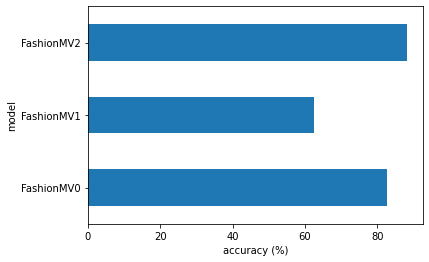

In [33]:
compare.set_index('model_')['accuracy'].plot(kind='barh')
plt.xlabel("accuracy (%)")
plt.ylabel('model')

In [37]:
def make_predictions(model, data, device=device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [45]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(test_samples[0].shape, test_labels[0], class_names[test_labels[0]])

torch.Size([1, 28, 28]) 5 Sandal


In [46]:
pred_probs = make_predictions(model_2, data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes, test_labels

(tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]), [5, 1, 7, 4, 3, 0, 4, 7, 1])

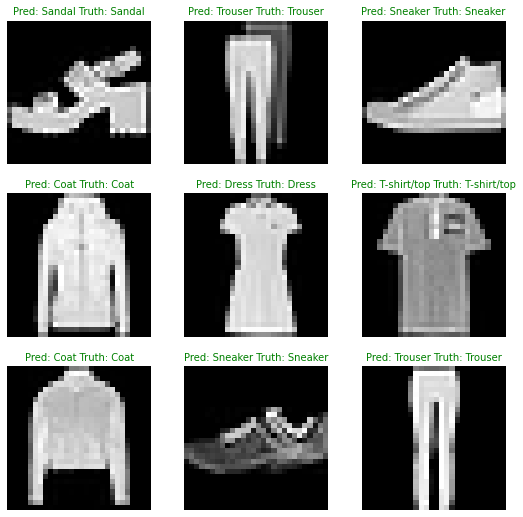

In [47]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c='g')
    else:
        plt.title(title_text, fontsize=10, c='r')
    plt.axis(False)

In [49]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

In [50]:
try:
    import torchmetrics, mlxtend
    assert int(mlxtend.__version__.split('.')[1] >= 19, 'mlxtend should be 0.19.0 or higher')
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print('MLXtend:', mlxtend.__version__)

C:\Users\InE_STD\anaconda3\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


MLXtend: 0.23.0



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


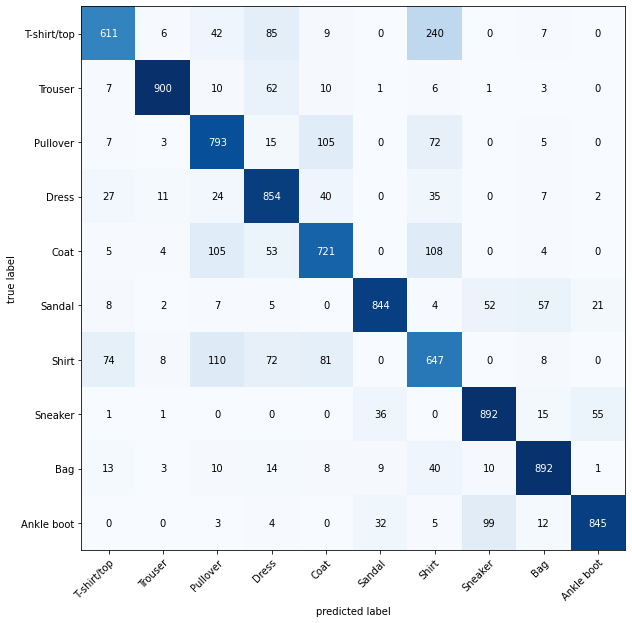

In [57]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(y_pred_tensor, test_data.targets)

fig, ax = plot_confusion_matrix(confmat_tensor.numpy(), figsize=(10, 10), class_names=class_names)

In [59]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = '03_pytorch_computer_vision_cnn_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

print('Saving model to', MODEL_SAVE_PATH)
torch.save(obj=model_2.state_dict(),f=MODEL_SAVE_PATH)

Saving model to models\03_pytorch_computer_vision_cnn_model.pth


In [61]:
torch.manual_seed(42)

loaded = FashionMV2(input_shape=1, hidden_units=10, output_shape=len(class_names))
loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded.to(device)

FashionMV2(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [64]:
torch.manual_seed(42)

loaded_result = eval_model(loaded, test_dataloader, loss_fn, accuracy_fn)

torch.isclose(torch.tensor(model_2_results['loss']), torch.tensor(loaded_result['loss']), atol=1e-08)

tensor(True)